# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import *
from src.datasets import *
from src.residual import get_volume_residual

import jax
import mrcfile
from jax.scipy.special import gammaln

plt.rcParams["figure.figsize"]=6,6

### TODO: maybe all the reading and pre-processing data should all be done in one function.
Then we can use this function in the run_ab_initio script and other notebooks (e.g. Volume residual)

See how it's done in the ```datasets.py``` file for the heterogeneous dataset. Move everything there.

### Read the data

In [3]:
# Out directory to save outputs
out_dir = '../data/out_dev/'

#### One real dataset

In [ ]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

#data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
#star_file = "/Extract/job018/particles.star"

#data_dir = "/gpfs/gibbs/pi/lederman/3DFSC_data/untilted/Particle-Stack/"
#star_file = "T40_HA_130K-Equalized_run-data.star"
#star_file = "T00_HA_130K-Equalized_run-data.star"

#data_dir = "/gpfs/gibbs/pi/lederman/EMPIAR-10028/"
#star_file = "shiny_2sets.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
#star_file = "particles_crossvalidation_train_1.star"
star_file = "particles_subset_5k.star"

#data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
#star_file = "Projections/crossvalidation1_sub/crossvalidation1_sub.star"

#data_dir = "/gpfs/gibbs/pi/lederman/dge5/SimulatedData/"
#star_file = "random_particles_128.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]

#### Or a custom heterogeneous dataset with 2 classes

In [4]:
nx = 64
N_set = [5000, 5000]

data_dir1 = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
star_file1 = "Extract/job020/particles.star"

data_dir2 = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file2 = "particles_subset_5k.star"

data_dirs = [data_dir1, data_dir2]
star_files = [star_file1, star_file2]

imgs0, imgs_f, ctf_params, pixel_size, angles, shifts, z, x_grid = create_het_dataset(data_dirs, star_files, N_set, nx)

N = imgs_f.shape[0]

Reading dataset 0


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  5090
load_data: data loaded, time:  7.2612464427948
imgs_0.shape = (5090, 256, 256)
pixel_size_0.shape = (5090,)
angles_0.shape = (5090, 3)
shifts_0.shape = (5090, 2)
ctf_params_0.shape = (5090, 9)
Taking FFT of dataset 0...9.272207975387573 seconds.
x_grid_0 = [3.13873214e-03 2.56000000e+02]
Cropped x_grid_0 = [3.13873214e-03 6.40000000e+01]
Reading dataset 1
load_data: number of partcles:  5000


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: data loaded, time:  29.94823956489563
imgs_1.shape = (5000, 320, 320)
pixel_size_1.shape = (5000,)
angles_1.shape = (5000, 3)
shifts_1.shape = (5000, 2)
ctf_params_1.shape = (5000, 9)
Taking FFT of dataset 1...13.766293287277222 seconds.
x_grid_1 = [2.38549618e-03 3.20000000e+02]
Cropped x_grid_1 = [2.38549618e-03 6.40000000e+01]


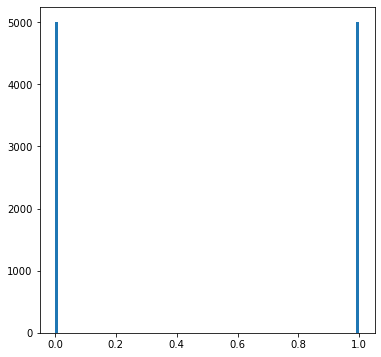

In [5]:
#plt.plot(z, '.')
nbins = 100
counts, bins = np.histogram(z, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

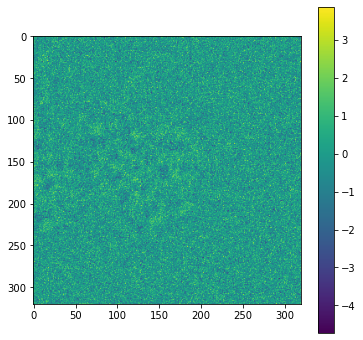

In [6]:
plt.imshow(imgs0[1][3]); plt.colorbar()

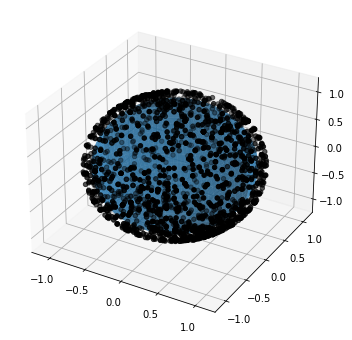

In [7]:
plot_angles(angles[np.random.permutation(imgs_f.shape[0])[:2000]])

z[2] = 0


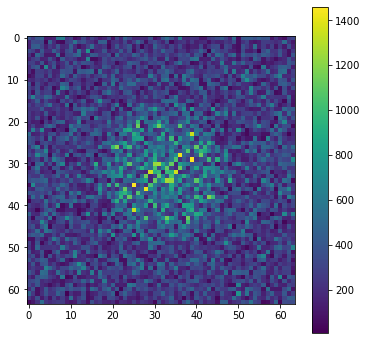

In [8]:
idx = 2
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[idx].reshape([nx,nx])))); plt.colorbar()
print(f"z[{idx}] = {z[idx]}")

z[1037] = 0


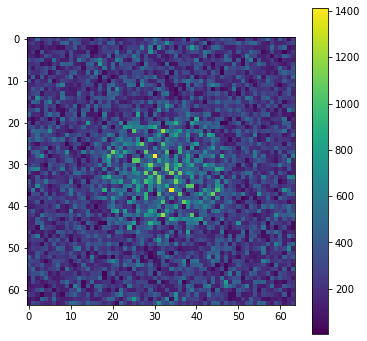

In [9]:
idx = 1037
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[idx].reshape([nx,nx])))); plt.colorbar()
print(f"z[{idx}] = {z[idx]}")

#### Or read 3 classes from Daniel's simulated data (TODO: move this to the ```datasets.py``` file)

In [ ]:
classes = [0, 4, 9]

data_dir = "/gpfs/gibbs/pi/lederman/dge5/SimulatedData/"
star_file = f"projections/volume{classes[0]}.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)


data_dir = "/gpfs/gibbs/pi/lederman/dge5/SimulatedData/"
star_file = f"projections/volume{classes[1]}.star"

params1, imgs1 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

data_dir = "/gpfs/gibbs/pi/lederman/dge5/SimulatedData/"
star_file = f"projections/volume{classes[2]}.star"

params2, imgs2 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

imgs0 = np.concatenate([imgs0, imgs1, imgs2], axis=0)

ctf_params0 = np.concatenate([params0["ctf_params"], params1["ctf_params"], params2["ctf_params"]], axis=0)
pixel_size0 = np.concatenate([params0["pixel_size"], params1["pixel_size"], params2["pixel_size"]], axis=0)
angles0 = np.concatenate([params0["angles"], params1["angles"], params2["angles"]], axis=0)
shifts0 = np.concatenate([params0["shifts"], params1["shifts"], params2["shifts"]], axis=0)

# Assuming all classes have the same number of images
Nk = imgs1.shape[0]
z_true0 = jnp.zeros((Nk,))
z_true1 = jnp.ones((Nk,))
z_true2 = 2*jnp.ones((Nk,))

z_true = jnp.concatenate([z_true0, z_true1, z_true2])

del(imgs1, imgs2, params0, params1, params2)

In [ ]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)
nx0 = imgs0.shape[-1]
#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

In [ ]:
plt.imshow(imgs0[1]); plt.colorbar()

In [ ]:
plot_angles(-angles0[np.random.permutation(imgs0.shape[0]-1)[:2000]])

#### Only keep N points at random (to avoid out of memory error)

In [ ]:
N = 5000 #imgs0.shape[0]

if N < imgs0.shape[0]:
    idxrand = np.random.permutation(imgs0.shape[0]-1)[:N]
else:
    idxrand = jnp.arange(N)
    
imgs0 = imgs0[idxrand]
pixel_size = pixel_size0[idxrand]
angles = angles0[idxrand]
shifts = shifts0[idxrand]
ctf_params = ctf_params0[idxrand]

z_true = z_true[idxrand]

file2 = open(out_dir + '/idxrand','wb')
pickle.dump(idxrand, file2)
file2.close()

In [ ]:
nbins = 100
counts, bins = np.histogram(z_true, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

#### Take the FFT of the images

In [ ]:
t0 = time.time()
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])
print(time.time()-t0)

#### Create the grids

In [ ]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

In [ ]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[103]))); plt.colorbar()

#### Crop images to 32 x 32 

In [ ]:
nx = 16 #64
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

In [ ]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[103].reshape([nx,nx])))); plt.colorbar()

#### Before further processing, vectorize the images, create mask etc

In [ ]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

In [ ]:
#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f2[103].reshape(nx,nx)))); plt.colorbar()

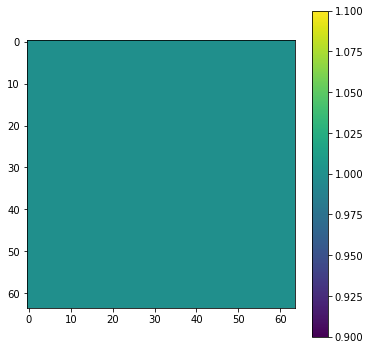

In [10]:
centre = (0,0,0)
#radius = 0.09 # for nx=32
radius = 0.185
#radius = 0.093 # nx-64
#radius = 0.074 *2
#radius = 0.07 # for nx=64
#radius = 0.198 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)

mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Estimate the noise

First, decide on the dimensions of the empty corners to use for noise estimation:

In [11]:
N_noise = 48
#plt.imshow(jnp.mean(imgs0[:,:N_noise,:N_noise], axis=0))

In [12]:
# Do this if imgs0 is a list of datasets
imgs0 = np.concatenate([imgs[:, :N_noise, :N_noise] for imgs in imgs0], axis=0)

# And shuffle in case we don't use the full dataset for noise estimation
imgs0 = imgs0[np.random.permutation(imgs0.shape[0])]

imgs0.shape

(10000, 48, 48)

Text(0.5, 1.0, 'Estimated noise')

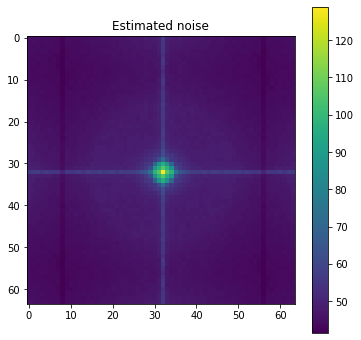

In [13]:
sigma_noise_estimated = estimate_noise_imgs(imgs0, nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

#### Average radially

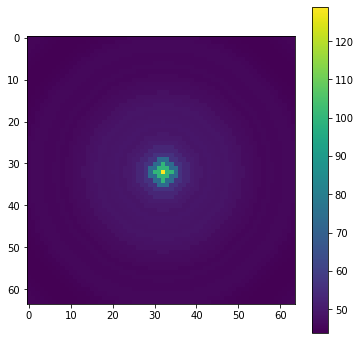

In [14]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)

plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

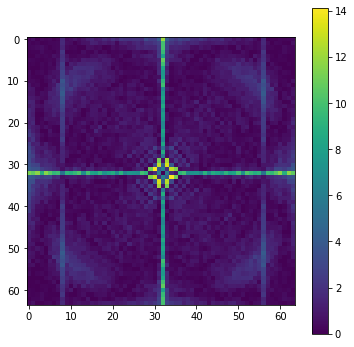

In [15]:
plt.imshow(jnp.fft.fftshift(jnp.abs(sigma_noise_avg-sigma_noise_estimated))); plt.colorbar()

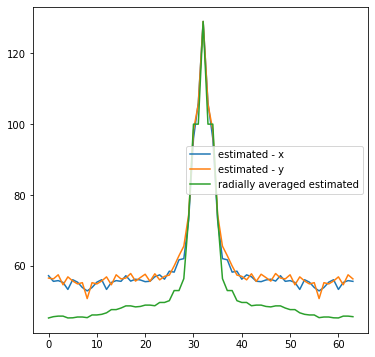

In [16]:
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[0,:]))
plt.plot(jnp.fft.fftshift(sigma_noise_avg[:,0]))
plt.legend(['estimated - x', 'estimated - y', 'radially averaged estimated'])

In [17]:
sigma_noise = sigma_noise_avg.reshape(-1)

#### Delete the real images
Since we only work with the Fourier ones from now on.

In [18]:
del(imgs0)
#del(imgs)

### Ab initio

Actual pixel size for 32 x 32 images is:

In [19]:
pixel_size[0]*(320/nx)

6.222655872195892

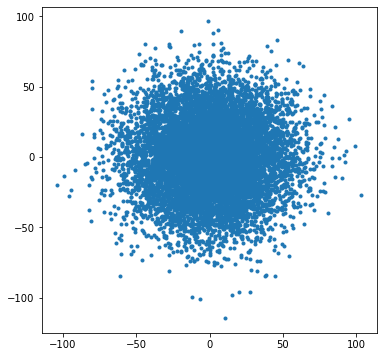

In [20]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
pixel_size_nx = pixel_size[0] * 320/nx
B = pixel_size_nx*nx/15

sh = generate_gaussian_shifts(key, N, B)
plt.plot(sh[:,0], sh[:,1], '.')

In [21]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [22]:
#sys.stdout = sys.__stdout__

In [23]:
#v_rec_int = v_rec
#angles_rec_int = angles_rec

In [24]:
# Split in batches, note that imgs_batch stays on the CPU (i.e. np not jnp)
N_batch = 1
imgs_batch = np.array(np.array_split(imgs_f, N_batch))
angles_batch = jnp.array(np.array_split(angles, N_batch))
shifts_batch = jnp.array(np.array_split(shifts, N_batch))
ctf_params_batch = jnp.array(np.array_split(ctf_params, N_batch))

Fourier radius: 0.10043942857142858
Starting radius: 0.01
Frequency marching step size: 0.005436443542778108
Number of frequency marching steps: 17
------------------------------------

Initialitsing volume
  sgd epoch 0: mean gradient = 1.543251914876889e-06


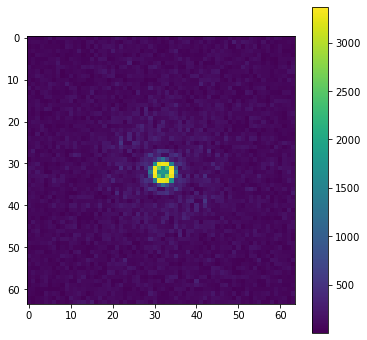

v.shape after initialization = (2, 64, 64, 64)
Iter  1
Sampling orientations
and class assignments
  MCMC sample 50 , posterior val = -1541.2192629812218
  MCMC sample 100 , posterior val = -1538.1593567019258
  MCMC sample 150 , posterior val = -1536.5894060259843
  MCMC sample 200 , posterior val = -1535.5281240367035
  MCMC sample 250 , posterior val = -1534.8194330378362
  MCMC sample 300 , posterior val = -1534.178685829021
  MCMC sample 350 , posterior val = -1533.7028023781636
  MCMC sample 400 , posterior val = -1533.262670038363
  MCMC sample 450 , posterior val = -1532.9922612693254
  MCMC sample 500 , posterior val = -1532.6592788983528
  MCMC sample 550 , posterior val = -1532.4248443934962
  MCMC sample 600 , posterior val = -1532.2064774210958


In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

# The number of iterations desn't matter, 
# since it stops when the volume is nx x nx x nx.
N_iter = 3000000

#radius0 =  0.15 #0.15  #0.06
#radius0 = 0.010
radius0 = 0.01
#radius0 = 0.04 #0.05
alpha = 1e-9  # <--- this is the working one
#alpha = 1e-6

sgd_batch_size = 300
sgd_learning_rate = 1e5 #1e6
eps_init = 1 #2e-7

N_samples_vol = 101   
N_samples_angles_global = 1001
N_samples_angles_local = 201
N_samples_shifts = 101
N_samples_z = 201

# HMC params
#dt = 5
dt_list_hmc = jnp.array([0.1, 0.5, 1, 5, 10])
L_hmc = 5

sigma_perturb_list = jnp.array([1, 0.1, 0.01, 0.001])

pixel_size_nx = pixel_size[0] # * nx0/nx
B = pixel_size_nx*nx/15
B_list = jnp.array([B, B/2, B/4, B/8])
freq_marching_step_iters = 8

vol0 = None
angles0 = None #angles_batch
shifts0 = shifts_batch
z0 = None
#sigma_noise = jnp.ones(sigma_noise.shape)

# Class assignment parameters
K = 2
alpha_d = 10*jnp.ones(K)
    
v_rec, angles_rec, shifts_recz, z_rec = ab_initio_mcmc(key, 
                                   project, 
                                   rotate_and_interpolate,
                                   apply_shifts_and_ctf,
                                   imgs_batch, 
                                   sigma_noise, 
                                   ctf_params_batch, 
                                   x_grid, 
                                   vol0,
                                   angles0,
                                   shifts0,
                                   z0,
                                   N_iter, 
                                   sgd_learning_rate, 
                                   sgd_batch_size, 
                                   N_samples_vol,
                                   N_samples_angles_global,
                                   N_samples_angles_local, 
                                   N_samples_shifts,
                                   N_samples_z,
                                   dt_list_hmc,
                                   sigma_perturb_list,
                                   L_hmc, 
                                   radius0, 
                                   None, 
                                   alpha, 
                                   eps_init,
                                   B_list,
                                   K, 
                                   alpha_d,
                                   freq_marching_step_iters,
                                   'tri', 
                                   True, True, True, True, out_dir)

In [ ]:
nbins = 100
counts, bins = np.histogram(z_rec, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
plot_angles(angles_rec[:2000])

In [ ]:
v_final = mrcfile.open(f"{out_dir}/rec_final.mrc").data
v_rec, _, _ = volume_fourier(v_final, pixel_size[0])
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,:,0])))

In [63]:
with open(f"{out_dir}/rec_iter_53_angles", 'rb') as file:
    # Call load method to deserialze
    angles_rec = pickle.load(file)
    angles_rec = angles_rec[0]
    

In [ ]:
plot_angles(angles_rec)

In [ ]:
theta, cord_distance = err_orientations(angles, angles_rec)

nbins=100
counts, bins = np.histogram(theta, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
v_rec_l, x_grid_l = rescale_larger_grid(v_rec, x_grid, 256)
v_rec_rl = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l)))
mip_z(v_rec_rl)
plt.colorbar()


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_alpha1e-9_nx0_ab_initio.mrc", overwrite=True) as mrc:
    mrc.set_data(v_rec_rl.astype(np.float32))

### MCMC vol

In [ ]:
#angles_rec = angles
#sigma_noise = jnp.ones(4096)

In [ ]:
plot_angles(angles_rec[:1000])

In [ ]:
#ctf_nones = []
#for i in range(N):
#    ctf_nones.append(None)
#ctf_params = jnp.array(ctf_nones)  


In [ ]:
N_batch = 1
imgs_batch = np.array(np.array_split(imgs_f, N_batch))
angles_batch = jnp.array(np.array_split(angles_rec, N_batch))
shifts_batch = jnp.array(np.array_split(shifts, N_batch))
ctf_params_batch = jnp.array(np.array_split(ctf_params, N_batch))

In [ ]:
alpha = 1e-9
#alpha = 1e-6
#alpha=1e-7

#radius = 0.048# for nx=32
radius = 0.075
#radius = 0.185
#radius = 1.6 # for nx=64
#radius = 0.198 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])
dt_list = jnp.array([0.1, 0.5, 1, 5, 10])
L = 5

pixel_size_nx = pixel_size[0] * 320/nx
B = pixel_size_nx*nx/15
B_list = jnp.array([B, B/2, B/4, B/8])

slice_func, _, _ = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, _, loss_func_sum = get_loss_funcs(slice_func, alpha = alpha)
_, loss_func_batched0, _ = get_loss_funcs(slice_func, alpha = 0)

grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

loss_proj_func_batched0 = get_loss_proj_funcs(apply_shifts_and_ctf, x_grid, alpha = 0)

proposal_func_orientations_u, proposal_func_orientations_p, proposal_func_shifts, proposal_func_vol, proposal_func_vol_batch = get_jax_proposal_funcs(
    loss_func_batched0, loss_proj_func_batched0, loss_func_sum, grad_loss_volume_sum, 
    sigma_noise, B_list, dt_list, L, M) 

#logPi = lambda v : -loss_func_sum(v, angles_rec, shifts_rec, ctf_params, imgs_f, sigma_noise)
#gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles_rec, shifts_rec, ctf_params, imgs_f, sigma_noise))
#gradLogPi = lambda v : gradLogPi_split(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise, 10)


In [ ]:
N_mc_samples = 101
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

v0 = (jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) )
#v0 = jnp.zeros([nx,nx,nx])*1j
#v0 = v_rec
#v0 = v_hmc_mean

params_vol = {'angles': angles_batch, 
              'shifts': shifts_batch, 
              'ctf_params': ctf_params_batch, 
            'imgs_iter': imgs_batch}

t0 = time.time()
v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, proposal_func_vol_batch, v0, N_mc_samples, params_vol, save_samples=-1)
print(time.time()-t0)


In [ ]:
print(jnp.mean(r_hmc))
plt.plot(r_hmc)

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_samples[0,:,:,0]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_mean[:,:,0]))); plt.colorbar()

In [ ]:
#v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_samples[0])))
v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))
mip_z(v_hmc_r)
plt.colorbar()

In [ ]:
with mrcfile.new(f"{out_dir}/v_hmc_mean_alpha{alpha}_pert_ang_2.mrc", overwrite=True) as mrc:
    mrc.set_data(v_hmc_r.astype(np.float32))

In [ ]:
v_hmc_mean_l, x_grid_l = rescale_larger_grid(v_hmc_mean, x_grid, 256)
v_hmc_rl = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean_l)))
mip_z(v_hmc_rl)
plt.colorbar()


In [ ]:
with mrcfile.new(f"{out_dir}/v_hmc_mean_alpha{alpha}_256_pert_ang_2.mrc", overwrite=True) as mrc:
    mrc.set_data(v_hmc_rl.astype(np.float32))
    


In [ ]:
file = open('../data/cryodrgn/angles_rec', 'wb')
pickle.dump(angles_rec, file)
file.close()

file3 = open('../data/cryodrgn/shifts_rec','wb')
pickle.dump(shifts_rec, file3)
file3.close()

In [ ]:
with open('../data/cryodrgn5000/angles_rec', 'rb') as file:
    # Call load method to deserialze
    angles_rec2 = pickle.load(file)
    
with open('../data/cryodrgn5000/shifts_rec', 'rb') as file:
    # Call load method to deserialze
    shifts_rec2 = pickle.load(file)
    
with open('../data/cryodrgn5000/angles_rec_img_idx', 'rb') as file:
    # Call load method to deserialze
    idxrand2 = pickle.load(file)    
    

In [ ]:
jnp.sum(jnp.abs(angles_rec2 - angles_rec))
jnp.sum(jnp.abs(shifts_rec2 - shifts_rec))
jnp.sum(jnp.abs(idxrand2 - idxrand))

### MCMC local perturbations for orientations

In [ ]:
#a0 = generate_uniform_orientations_jax(subkey, jnp.zeros(N))
a0 = angles_rec

In [ ]:
print(a0[0])
key, subkey = random.split(key)
a1, _, _, _= proposal_func_orientations_p(subkey, a0, jnp.inf*jnp.ones(N), v_hmc_mean, shifts, ctf_params, imgs_f, jnp.array([0.01]))
print(a1[0])

In [ ]:
N_mc_samples = 3000
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
key, subkey = random.split(key)

sigma_perturb_list = jnp.array([1, 0.1, 0.01, 0.001])

params_angles = {'v': v_hmc_mean, 
              'shifts': shifts, 
              'ctf_params': ctf_params, 
            'imgs_iter': imgs_f,
             'sigma_perturb' : sigma_perturb_list}

t0 = time.time()
_, angles_r, angles_samples = mcmc(key, proposal_func_orientations_p, a0, N_mc_samples, params_angles, N, save_samples=1)
print(time.time()-t0)

angles_rec2 = angles_samples[N_mc_samples-2]

In [ ]:
img_idx = 119
ang_idx = 2
plt.plot(jnp.mod(jnp.abs(angles_samples[:,img_idx,ang_idx] - angles[img_idx,ang_idx]), 2*jnp.pi))

In [ ]:
plt.plot(jnp.mod(jnp.abs(angles_samples[:,img_idx,ang_idx] - angles_rec[img_idx,ang_idx]), 2*jnp.pi))

In [ ]:
theta, cord_distance = err_orientations(angles, angles_rec)

nbins=100
counts, bins = np.histogram(theta, bins=nbins)
plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
theta, cord_distance = err_orientations(angles, angles_rec2)

nbins=100
counts, bins = np.histogram(theta, bins=nbins)
plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
theta, cord_distance = err_orientations(angles_rec, angles_rec2)

nbins=100
counts, bins = np.histogram(theta, bins=nbins)
plt.hist(bins[:-1], bins, weights=counts)

### Classes

In [ ]:
# Load the correct volumes

print(classes)

vols = []
vols_r = []
for i in classes:
    with mrcfile.open(f"/gpfs/gibbs/pi/lederman/dge5/SimulatedData/{i}_volume.mrc") as file:
        v = file.data
        
    v_f, _, _ = volume_fourier(v, pixel_size[0])
    v_f, _ = crop_fourier_volume(v_f, x_grid, 16)  
    
    v_r = jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(v_f)))
    
    vols.append(v_f)                 
    vols_r.append(v_r)
    
vols = jnp.array(vols)
vols_r = jnp.array(vols_r)
# Crop them


In [ ]:
#v_f = np.fft.fftshift(v_f)

mip_z((jnp.abs(vols_r[0]))); plt.colorbar()

In [ ]:

plt.imshow(jnp.abs((v_f[0]))); plt.colorbar()

In [ ]:
mip_z(vols_r[0])

In [ ]:
def get_class_proposal_func(loss_func_batched, loss_func_sum, sigma_noise, alpha_d, K):
    

    
    def logPi(v, angles, shifts, ctf_params, imgs, z, sigma_noise):
        n_k = calc_nk_jit(z)
        term1 = -loss_func_sum(v, angles, shifts, ctf_params, imgs, z, sigma_noise)

        logPZalpha = jnp.sum(gammaln(n_k + alpha_d))            

        return term1 + logPZalpha
 
    calc_nk_k = lambda z, k : jnp.sum(z == k)
    calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
    calc_nk_jit = jax.jit(calc_nk)

    @jax.jit
    def proposal_z_idx(key, z0, logPiX0, v, angles, shifts, ctf_params, imgs, idx):
        
        logPi_local = lambda z : logPi(v, angles, shifts, ctf_params, imgs, z, sigma_noise)
        
        newval = random.randint(key, (), 0, K) 
        z1 = z0.at[idx].set(newval)

        logPiX0 = logPi_local(z0)
        logPiX1 = logPi_local(z1)

        r = jnp.exp(logPiX1 - logPiX0)

        return z1, r, logPiX1, logPiX0

    @jax.jit
    def proposal_z_batch_old(key, z0, logPiX0, v, angles, shifts, ctf_params, imgs):
        """Batch mode proposal function for z, operating in the same
        way as proposal_x_batch. 

        If the posterior depends on the states z_1,...,z_N (e.g. due to 
        the Dirichlet prior), then running MCMC with this proposal function
        is NOT correct. However, this function is used in the
        proposal_z_batch_correct" function, which takes advantage of these
        parallel proposals in a proper MCMC way."""
   
        N = angles.shape[0]
        keys = random.split(key, N)

        # TODO: change both batch functions (this and proposal_x_batch)
        # so we don't have to do diag on an N x N (or K x K) matrix - potentially
        # problematic for large N.
        z1, r, logPiX1, logPiX0 = jax.vmap(proposal_z_idx, 
                                           in_axes = (0, None, None, None, None, None, None, None, 0))(keys, z0, logPiX0, v, angles, shifts, ctf_params, imgs, jnp.arange(N))
        z1 = jnp.diag(z1)

        return z1, r, logPiX1, logPiX0
    
    
    @jax.jit
    def proposal_z_batch(key, z0, logPiX0, v, angles, shifts, ctf_params, imgs):
        """Batch mode proposal function for z, with no Dirichlet prior 
        for the classes.

        If the posterior depends on the states z_1,...,z_N (e.g. due to 
        the Dirichlet prior), then running MCMC with this proposal function
        is NOT correct. However, this function is used in the
        proposal_z_batch_correct" function, which takes advantage of these
        parallel proposals in a proper MCMC way."""
   
        N = angles.shape[0]
        z1 = random.randint(key, z0.shape, 0, K) 

        logPiX0 = -loss_func_batched(v, angles, shifts, ctf_params, imgs, z0, sigma_noise)
        logPiX1 = -loss_func_batched(v, angles, shifts, ctf_params, imgs, z1, sigma_noise)
        r = jnp.exp(logPiX1 - logPiX0)

        return z1, r, logPiX1, logPiX0

    @jax.jit
    def proposal_z_batch_correct(key, z0, logPiX0, v, angles, shifts, ctf_params, imgs):
        """If using the Dirichlet posterior, then the proposal_z_batch is not 
        proper MCMC sampling. Here, we run a number of "incorect" MCMC steps to 
        sample all the entries of z in parallel, and then use the latest 
        proposed z as a proposal for a "correct" MCMC proposal. The acceptance rate
        is pretty good in this toy example and the convergence great."""
        
        logPi_local = lambda z : logPi(v, angles, shifts, ctf_params, imgs, z, sigma_noise)
    
        N = angles.shape[0]
        N_samples_z_local = 10
        keys = random.split(key, 2*N_samples_z_local)
        params_z = {"v" : v, "angles" : angles, "shifts" : shifts, "ctf_params" : ctf_params, "imgs" : imgs}

        logPiZ0 = logPi_local(z0)
        
        #logPiX0 = logPiZ0
        #for i in jnp.arange(N_samples_z_local):
        #    z1, r, logPiX1, logPiX0 = proposal_z_batch(keys[2*i], z0, logPiX0, **params_z)
        #    a = jnp.minimum(1, r)
        #    
        #    unif_var = random.uniform(keys[2*i+1], (N,))
        #    z1, logPiX1 = accept_reject_vmap(unif_var, a, z0, z1, logPiX0, logPiX1)
        #    
        #    z0 = z1
        #    logPiX0 = logPiX1
        
        def body_fun(i, z0logPiX0):
            z0, logPiX0 = z0logPiX0
            
            z1, r, logPiX1, logPiX0 = proposal_z_batch(keys[2*i], z0, logPiX0, **params_z)
            a = jnp.minimum(1, r)

            unif_var = random.uniform(keys[2*i+1], (N,))
            z1, logPiX1 = accept_reject_vmap(unif_var, a, z0, z1, logPiX0, logPiX1)

            return z1, logPiX1

        z1, _ = jax.lax.fori_loop(0, N_samples_z_local, body_fun, (z0, logPiZ0*jnp.ones((N,))))    
                         
        logPiZ1 = logPi_local(z1)
        r = jnp.exp(logPiZ1 - logPiZ0)       

        return z1, r, logPiZ1, logPiZ0
    
    return proposal_z_idx, proposal_z_batch, proposal_z_batch_correct

In [ ]:
K = len(classes)
alpha_d = 10* jnp.ones(K)

alpha = 1e-9
#alpha = 1e-6
#alpha=1e-7

#radius = 0.048# for nx=32
radius = 0.09
#radius = 0.185
#radius = 1.6 # for nx=64
#radius = 0.198 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])
dt_list = jnp.array([0.1, 0.5, 1, 5, 10])
L = 5

pixel_size_nx = pixel_size[0] * 320/nx
B = pixel_size_nx*nx/15
B_list = jnp.array([B, B/2, B/4, B/8])

slice_func, _, _ = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum = get_loss_funcs(slice_func, alpha = alpha)
_, loss_func_batched0, _ = get_loss_funcs(slice_func, alpha = 0)

grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

loss_proj_func_batched0 = get_loss_proj_funcs(apply_shifts_and_ctf, x_grid, alpha = 0)



#logPi = lambda v : -loss_func_sum(v, angles_rec, shifts_rec, ctf_params, imgs_f, sigma_noise)
#gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles_rec, shifts_rec, ctf_params, imgs_f, sigma_noise))
#gradLogPi = lambda v : gradLogPi_split(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise, 10)



loss_func_z, loss_func_z_batched, loss_func_z_sum, grad_loss_volume_z, grad_loss_volume_sum_z = get_loss_grad_funcs_classes(loss_func)

proposal_z_idx, proposal_z_batch, proposal_z_batch_correct = get_class_proposal_func(loss_func_z_batched, loss_func_z_sum, sigma_noise, alpha_d, K)

proposal_func_orientations_u, proposal_func_orientations_p, proposal_func_shifts, proposal_func_vol, proposal_func_vol_batch = get_jax_proposal_funcs(
    loss_func_z_batched, loss_proj_func_batched0, loss_func_z_sum, grad_loss_volume_sum_z, 
    sigma_noise, B_list, dt_list, L, M) 

In [ ]:
Nn = N

N_iters = 10
N_samples_z = 201
N_samples_v = 201
N_samples_a = 1001
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

sample_v = False
sample_z = True
sample_a = False

#v0 = jnp.array(np.random.randn(K, nx,nx,nx) + 1j * np.random.randn(K, nx,nx,nx)) 
v0 = vols.astype(jnp.complex128)

z0 =  jnp.array(np.random.randint(0, K, (Nn,)))

#a0 = generate_uniform_orientations_jax(key, angles)
a0 = angles[:Nn]


vi = v0
zi = z0
ai = a0

t0 = time.time()

for iter_i in jnp.arange(N_iters):
    print(f"Iter = {iter_i}")

    if sample_v:
        print("  Sampling vols")

        params_v = {'angles': ai[:Nn], 
                    'shifts': shifts[:Nn], 
                    'ctf_params': ctf_params[:Nn], 
                    'imgs_iter': imgs_f[:Nn], 
                     'z' : zi[:Nn]}
        
        key, subkey = random.split(key)
        
        v_mean, v_r, v_samples = mcmc(subkey, proposal_func_vol, vi, N_samples_v, params_v, save_samples=-1)

        vi = v_samples[N_samples_v - 2]

    if sample_z:
        print("  Sampling z")

        params_z = {'v' : vi,
                    'angles': ai[:Nn], 
                    'shifts': shifts[:Nn], 
                    'ctf_params': ctf_params[:Nn], 
                    'imgs': imgs_f[:Nn]
                   # 'idx' : idx
                   }

        key, subkey = random.split(key)
     
        #v_hmc_mean, r_hmc, v_hmc_samples = mcmc(subkey, proposal_func_vol_batch, v0, N_mc_samples, params_vol, save_samples=-1)
        
        #_, z_r, z_samples = mcmc(subkey, proposal_z_batch, zi, N_samples_z, params_z, Nn, save_samples=1)
        _, z_r, z_samples = mcmc(subkey, proposal_z_batch_correct, zi, N_samples_z, params_z, 1, save_samples=1)
        zi = z_samples[N_samples_z - 2]
        
        
    if sample_a:
        print("  Sampling orientations")
        
        params_a = {'v': vi,
                    'shifts': shifts[:Nn], 
                    'ctf_params': ctf_params[:Nn], 
                    'imgs_iter': imgs_f[:Nn],
                    'z' : zi[:Nn]}
        
        key, subkey = random.split(key)
        
        _, a_r, a_samples = mcmc(key, proposal_func_orientations_u, ai, N_samples_a, params_a, Nn, 1, verbose = True)       
        ai = a_samples[N_samples_a - 2]      
                    
                    

v_rec = vi
print(time.time()-t0)

In [ ]:
v_rec_r = jnp.array([ jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(v))) for v in v_rec])

In [ ]:
idx = 4

#plt.plot(z_r[:,idx])
plt.plot(z_r)

In [ ]:
plt.plot(z_samples[:,1213])

In [ ]:
z_samples.shape

In [ ]:
nbins=100
counts, bins = np.histogram(z_samples[:,idx], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

v_idx = jnp.bincount(z_samples[:,idx]).argmax()

In [ ]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(imgs_f[idx].reshape([nx,nx])))))

In [ ]:
#v_idx = 0

plt.rcParams["figure.figsize"]=12,6
plt.subplot(2,2,1)
mip_y(vols_r[v_idx]); plt.colorbar()
plt.title("Ground truth")

plt.subplot(2,2,2)
mip_y(v_rec_r[v_idx]); plt.colorbar()
plt.title("Reconstruction")

plt.subplot(2,2,3)
mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v0[v_idx])))); plt.colorbar()
plt.title("Initialization")

plt.rcParams["figure.figsize"]=6,6

In [ ]:
mip_x(v_rec_r[0]); plt.colorbar()


In [ ]:
#for i in range(K):
#    with mrcfile.new(f"{out_dir}/class{i}_Dir.mrc", overwrite=True) as mrc:
#        mrc.set_data(v_rec_r[i].astype(np.float32))

In [ ]:
plt.rcParams["figure.figsize"]=12,6
plt.subplot(1,2,1)
sl = slice_func(vols[v_idx], angles[idx], shifts[idx], ctf_params[idx])
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(sl.reshape([nx,nx])))))

plt.subplot(1,2,2)
sl = slice_func(v_rec[v_idx], angles[idx], shifts[idx], ctf_params[idx])
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(sl.reshape([nx,nx])))))

plt.rcParams["figure.figsize"]=6,6

In [ ]:
print(f"v_idx = {v_idx}")
print(f"z_true[{idx}] = {z_true[idx]}")
assert z_true[idx] == v_idx, f"{z_true[idx]} != {v_idx} !!!"

In [ ]:
plt.plot(z0-z_true[:Nn])

In [ ]:
plt.plot(zi-z_true[:Nn])

In [ ]:
print(jnp.sum(jnp.abs(z0-z_true[:Nn]))/len(z_true))
print(jnp.sum(jnp.abs(zi-z_true[:Nn]))/len(z_true))

### MCMC orientations and shifts

In [ ]:
vol = mrcfile.open('../data/cryodrgn5000_noshifts/rec_final.mrc').data
vol_fourier, _, _ = volume_fourier(vol, pixel_size[0])
plt.imshow(jnp.fft.fftshift(jnp.abs(vol_fourier[:,:,0])))

In [ ]:
with open('../data/cryodrgn5000_noshifts/rec_iter_128_angles', 'rb') as file:
    # Call load method to deserialze
    angles_vol = pickle.load(file)
angles_vol = angles_vol[0]

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
pixel_size_nx = pixel_size[0] * 320/nx
B = pixel_size_nx*nx/30

sh = generate_gaussian_shifts(key, N, B)
plt.plot(sh[:,0], sh[:,1], '.')

In [ ]:
jnp.max(shifts)

In [ ]:
keys = random.split(key, 2)
keys[0]

In [ ]:
@jax.jit
def rotate_and_interpolate_iter(v, angles):
    return jax.vmap(rotate_and_interpolate, in_axes=(None,0,None,None))(v, angles, x_grid, x_grid)


In [ ]:
@jax.jit
def proposal_func_os(key, os0, logPiX0, v, ctf_params, imgs, B):
    # as0.shape = (N, 5) (3 angles and 2 shifts)
    keys = random.split(key, 2)
    
    N = os0.shape[0]
    #angles1 = generate_uniform_orientations_jax(keys[0], N)
    angles1 = os0[:,:3]
    #print(os0[0])
    #print(angles1[0])
    proj = rotate_and_interpolate_iter(v, angles1)
    
    
    shifts1 = generate_gaussian_shifts_batch(keys[1], 100, 200, B)
    shifts1 = jnp.concatenate([jnp.zeros([1,200,2]), shifts1], axis=0)

    loss_shifts1 = jax.vmap(loss_proj_func_batched0, in_axes=(None,None,0,None,None,None))(v, proj, shifts1, ctf_params, imgs, sigma_noise)
    
    min_loss_idx = jnp.argmin(loss_shifts1, axis=0)
    min_loss_shifts1 = shifts1[min_loss_idx, jnp.arange(shifts1.shape[1])]
                
    logPiX0 = jax.lax.cond(jnp.sum(logPiX0) == jnp.inf, 
                           true_fun = lambda _ : -loss_proj_func_batched0(v, rotate_and_interpolate_iter(v, os0[:,:3]), os0[:,3:], ctf_params, imgs, sigma_noise),
                           false_fun = lambda _ : logPiX0,
                           operand = None)
        
    logPiX1 = -loss_proj_func_batched0(v, proj, min_loss_shifts1, ctf_params, imgs, sigma_noise)
    
    #print(logPiX1.shape)
    #print(logPiX0.shape)
    
    r = jnp.exp(logPiX1 - logPiX0)
    os1 = jnp.concatenate([angles1, min_loss_shifts1], axis=1)
    #print(r.shape)
    return os1, r, logPiX1, logPiX0
    
    
    
    

In [ ]:
N_samples_shifts = int(10)
logPiX0 = -10000*jnp.ones(200)
os0 = jnp.zeros([200,5])
os1 = os0
logPiX1 = logPiX0

                 

In [ ]:
for i in range(10):
    key, subkey = random.split(key)
    os1, r, logPiX1, logPiX0 = proposal_func_os(subkey, os1, logPiX1, vol_fourier, ctf_params[:200], imgs_f[:200], B)
    if jnp.mod(i,1)==0:
        print(os1[0])

In [ ]:
B = 15
N_mc_samples = 1001
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

angles0 = angles_vol[:200]
shifts0 = jnp.zeros([200,2])
os0 = jnp.concatenate([angles0, shifts0], axis=1)

params_os = {'v':vol_fourier, 'ctf_params':ctf_params[:200], 'imgs':imgs_f[:200], 'B':B}

t0 = time.time()
_, r_os, os_samples = mcmc(key, proposal_func_os, os0, N_mc_samples, params_os, 200, save_samples=-1)
print(time.time()-t0)
os_samples = os_samples[0]
angles_rec = os_samples[:,:3]
shifts_rec = os_samples[:,3:]

In [ ]:
plt.plot(r_os[:,105])

In [ ]:
r_os.shape[0]

In [ ]:
serr = wrap_arround_distance_2d_array(shifts[:200], shifts_rec, pixel_size_nx * 32)
plt.plot(serr)
print(jnp.mean(serr))

In [ ]:
plt.plot(shifts[:200,0], shifts[:200,1], '.')
plt.plot(shifts_rec[:200,0], shifts_rec[:200,1], '.r')


In [ ]:
plt.plot(shifts[:200,0], shifts[:200,1], '.')


In [ ]:
idx = 188
aa = jnp.array([angles_vol[idx], angles_rec[idx]])
aa0 = jnp.array([angles_vol[idx], os0[idx, :3]])

plot_angles(aa0)

In [ ]:
plot_angles(aa)

In [ ]:
jnp.argmin(serr)

In [ ]:
s0 = slice_func(vol_fourier, angles_vol[0], shifts[0], ctf_params[0])
s1 = slice_func(vol_fourier, angles_rec[0], shifts[0], ctf_params[0])


In [ ]:
shifts[0]

In [ ]:
shifts_rec[0]

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0.reshape(64,64))));plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s1.reshape(64,64))));plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs((s1-s0).reshape(64,64))));plt.colorbar()

### MCMC shifts

In [ ]:
@jax.jit
def rotate_and_interpolate_iter(v, angles):
    return jax.vmap(rotate_and_interpolate, in_axes=(None,0,None,None))(v*mask, angles, x_grid, x_grid)

In [ ]:
# OOM if all at once for many images
#t0 = time.time()
#proj = rotate_and_interpolate_iter(v_hmc_mean, angles)
#print(time.time() - t0)

In [ ]:
t0 = time.time()
proj_batch = jnp.array([rotate_and_interpolate_iter(v_hmc_mean, angles_batch[i]) for i in jnp.arange(angles_batch.shape[0])])
#proj = jnp.concatenate(proj, axis=0)
print(time.time() - t0)
proj_batch.shape

In [ ]:
shifts.shape

In [ ]:
shifts_batch.shape

In [ ]:
shifts0.shape

In [ ]:
jnp.array(shifts_batch.shape[:2]) 

In [ ]:
len(N_batch_shape)

In [ ]:
angles_batch.shape[:2]

In [ ]:
imgs_batch.shape[:2]

In [ ]:
N_samples_shifts = 201

shifts0 = jnp.array(np.random.randn(4, shifts_batch.shape[1],2))
params_shifts = {'v':v_hmc_mean, 'proj':proj_batch[:4]}
N_batch_shape = jnp.array([4,5000])

t0 = time.time()
_, r_samples_shifts, samples_shifts = mcmc(key, proposal_func_shifts, shifts0, N_samples_shifts, params_shifts, N_batch_shape, 1, verbose = True)
shifts_rec_mc = samples_shifts[N_samples_shifts-2]
print(time.time()-t0)

In [ ]:
r_samples_shifts = r_samples_shifts.reshape(N_samples_shifts-1, -1)
samples_shifts = samples_shifts.reshape(N_samples_shifts-1, -1, 2)

In [ ]:
plt.plot(r_samples_shifts[:,0])

In [ ]:
shifts_rec_mc = samples_shifts[0]
shifts_rec_mc.shape

In [ ]:
shifts_batch.shape

In [ ]:
shifts0.shape

In [ ]:
err = shifts_rec_mc - shifts[:20000]
err0 = shifts0.reshape(20000,2) - shifts[:20000]

plt.scatter(err[:,0], err[:,1])

In [ ]:
print(jnp.max(shifts))
print(jnp.mean(jnp.abs(err)))
print(jnp.mean(jnp.abs(err0)))

In [ ]:
shifts_rec_mc

In [ ]:
jnp.min(shifts)

### CG - choosing $\alpha$

In [ ]:
centre = (0,0,0)
#radius = 0.045
radius = 0.093
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [ ]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

The noise

In [ ]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [ ]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [ ]:
N_iter = 50100
eps = 1e-4
#eps = 1e-5
#eps = 1e-3
#eps = 1e-6
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = [1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8]
alphas = [1e-8]
vcgs = []
fids = []
regs = []
losss = []
angles_cg = angles

In [ ]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_cg, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

In [ ]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(['fid', 'reg', 'fid+reg'])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

Pixel-wise loss for the best reconstruction:

In [ ]:
mask.shape

In [ ]:
def pixel_wise_fid_fun(v, slice_func_array, angles, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

In [ ]:
alphas[alpha_idx]

In [ ]:
sigma_noise1 = jnp.ones(sigma_noise.shape)

In [ ]:
pw_fid = pixel_wise_fid_fun(vcgs[0], slice_func_array, angles, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

In [ ]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [ ]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

In [ ]:
#alpha_idx = 2

In [ ]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

In [ ]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_cg[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

In [ ]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')


In [ ]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### All images are the same, with different scalings (corresponding to different orders of $\alpha$)

In [ ]:
vcgs_s = vcgs[:,:,0,0]
vcgs_s.shape

In [ ]:
plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1])*9)
plt.plot(jnp.abs(vcgs_s[2])*90)
plt.plot(jnp.abs(vcgs_s[3])*900)
plt.plot(jnp.abs(vcgs_s[6])*9e5)
plt.plot(jnp.abs(vcgs_s[8])*9e7)
plt.plot(jnp.abs(vcgs_s[10])*9e8)

### FSC, orientations, standard deviation for each voxel etc

In [ ]:
vcg1 = vcgs[0]
vcg2 = vcgs[6]

In [ ]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid)

In [ ]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 1000)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

In [ ]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA(vones)
omega = 1/omega

In [ ]:
jnp.min(jnp.abs(omega))

In [ ]:
plt.title("Standard deviation")
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))); plt.colorbar()

### SGD

### Preconditioner

In [ ]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

In [ ]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### $\alpha$ tuning

In [ ]:
mask2d = mask[:,:,0]
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [ ]:
N_epoch = 501000
batch_size = 300
#learning_rate = 100000
learning_rate = 10000 * 100
#learning_rate = 10000 # for "large" alpha

P = None

#eps = 3e-5
#eps = 1e-3
#eps = 1e-9
eps = 1e-8
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = 1/100 * jnp.array([1e-9, 1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]) #, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8, 1e-7]
alphas = [1e-9]

angles_gd = angles

In [ ]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_sum, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

In [ ]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha= len(fids)

In [ ]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

In [ ]:
alphas[2]

In [ ]:
#alpha_idx= 3
#alpha_idx=5
#alpha_idx=0

In [ ]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

In [ ]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

In [ ]:
#err = vgds[1] - v_rec
#plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

In [ ]:
vgds_s = vgds[:,:,0,0]
vgds_s.shape

plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1])*1.1)
plt.plot(jnp.abs(vgds_s[2])*2)
plt.plot(jnp.abs(vgds_s[3])*7)


In [ ]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
with mrcfile.new('../data/reconstruction_data_32_sgd_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [ ]:
idx = 100

In [ ]:
slicegd = slice_func(vgds[alpha_idx], angles_gd[idx], shifts[idx], ctf_params[idx])
#slicerec = slice_func(v_rec, angles_gd[idx], shifts[idx], ctf_params[idx])

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([nx,nx])))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([nx,nx])))); plt.colorbar()

### C3 Symmetry

In [ ]:
def split(arr):
    N = arr.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    arr_train = arr[:N2]
    arr_test  = arr[N2:]
    
    return arr_train, arr_test

def split_and_triple(arr):
    N = arr.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    arr_train = jnp.tile(arr[:N2], reps=(3,1))
    arr_test  = jnp.tile(arr[N2:], reps=(3,1))
    
    return arr_train, arr_test

def split_and_triple_angles(a):
    N = a.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    a_train1 = a[:N2]
    a_train2 = a_train1.copy()
    a_train3 = a_train1.copy()

    a_train2[:,2] += 2*jnp.pi/3
    a_train3[:,2] += 4*jnp.pi/3
   
    a_train = jnp.concatenate([a_train1, a_train2, a_train3], axis=0)
    
    a_test1  = a[N2:]
    a_test2 = a_test1.copy()
    a_test3 = a_test1.copy()

    a_test2[:,2] += 2*jnp.pi/3
    a_test3[:,2] += 4*jnp.pi/3
    
    a_test = jnp.concatenate([a_test1, a_test2, a_test3], axis=0)


    return a_train, a_test

In [ ]:
imgs_train, imgs_test = split_and_triple(imgs_f)
shifts_train, shifts_test = split_and_triple(shifts)
ctf_params_train, ctf_params_test = split_and_triple(ctf_params)
angles_train, angles_test = split_and_triple_angles(angles)
N = imgs_train.shape[0]

#plot_angles(angles[:1000])

In [ ]:
#imgs_train, imgs_test = split(imgs_f)
#shifts_train, shifts_test = split(shifts)
#ctf_params_train, ctf_params_test = split(ctf_params)
#angles_train, angles_test = split(angles)
#N = imgs_train.shape[0]
#plot_angles(angles_train)

### Volume residual

In [ ]:
plt.plot(angles[:,1])

In [ ]:
p1 = np.random.randn(N) * 0 #np.pi/20
p2 = np.random.randn(N) * 0 #np.pi/40 + np.pi/2
p3 = np.random.randn(N) * np.pi/10

angles_train_pert = angles_train + jnp.array([p1,p2,p3]).transpose()

In [ ]:
N

In [ ]:
idx = 102
aa = jnp.array([angles_train[idx], angles_train_pert[idx]])
plot_angles(aa)

In [ ]:
#angles_rec = angles_train
angles_rec = angles_train_pert

In [ ]:
alpha = 1e-9
N_train = jnp.floor(N/2).astype(jnp.int32) #3000

radius = 0.0925
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])

slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

logPi = lambda v : -loss_func_sum(v, angles_rec, shifts_train, ctf_params_train, imgs_train, sigma_noise)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles_rec, shifts_train, ctf_params_train, imgs_train, sigma_noise))


In [ ]:
N_mc_samples = 101
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

v0 = jnp.zeros([nx,nx,nx])*1j
dt_list = jnp.array([0.01, 0.1, 0.5, 5, 10])
proposal_params_hmc = {"dt_list" : dt_list, "L" : 10, "M" : M, "gradLogPi" : gradLogPi}

t0 = time.time()
v_rec_pert, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, v0, proposal_params_hmc)
print(time.time()-t0)

In [ ]:
N

In [ ]:
print(jnp.mean(r_hmc))
plt.plot(r_hmc)

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec_pert[:,:,0]))); plt.colorbar()

In [ ]:
v_rec_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_pert)))
mip_z(v_rec_r)
plt.colorbar()

In [ ]:
with mrcfile.new('../data/3dfsc/v_rec_vol_hmc_64_triple_pert.mrc', overwrite=True) as mrc:
    mrc.set_data(v_rec_r.astype(np.float32))

In [ ]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([64,64])))

In [ ]:
from src.residual import *

### From Relion residuals

In [ ]:
N_batches = 60000000
#v_resid = get_volume_residual(v_rec, angles[N_train:N_train+2000], shifts[N_train:N_train+2000], ctf_params[N_train:N_train+2000], imgs_f[N_train:N_train+2000], sigma_noise, x_grid, slice_func_array, N_batches)

v_resid_pert = get_volume_residual(imgs_f, angles, sigma_noise, x_grid, slice_func_array, N_batches)
                   

In [ ]:
imgs_f.shape

In [ ]:
#proj_coords, resid = voxel_wise_resid_from2d_fun(imgs_f, angles, sigma_noise, x_grid, slice_func_array)
                                                 
                                                 
                                                 

In [ ]:
resid.shape

In [ ]:
plt.imshow(jnp.fft.fftshift(v_resid_pert[:,:,0]*mask[:,:,0])); plt.colorbar()

In [ ]:
v_resid_print = jnp.fft.fftshift(v_resid_pert*mask)
with mrcfile.new('../data/cryodrgn_jupyter/v_resid_64_pert.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))

In [ ]:
v_resid_zero = get_volume_residual(jnp.zeros(v_rec.shape), angles_test, shifts_test, ctf_params_test, imgs_test, sigma_noise, x_grid, slice_func_array, N_batches)


In [ ]:
plt.imshow(jnp.fft.fftshift(v_resid_zero[:,:,0]*mask[:,:,0])); plt.colorbar()

In [ ]:
v_resid_zero_print = jnp.fft.fftshift(v_resid_zero*mask)
with mrcfile.new('../data/3dfsc/v_resid_64_zero.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_zero_print.astype(np.float32))

In [ ]:
v_resid_m = jnp.fft.fftshift(v_resid*mask)
v_resid_pert_m = jnp.fft.fftshift(v_resid_pert*mask)
v_resid_zero_m = jnp.fft.fftshift(v_resid_zero*mask)

In [ ]:
jnp.max(v_resid_m)

In [ ]:
jnp.max(v_resid_zero_m)

In [ ]:
print(jnp.max(v_resid_m))
print(jnp.max(v_resid_pert_m))
print(jnp.max(v_resid_zero_m))
plot_vmax = jnp.max(jnp.array([v_resid_m, v_resid_pert_m, v_resid_zero_m]))
#plot_vmax = jnp.max(jnp.array([v_resid_m, v_resid_zero_m]))

print(plot_vmax)

In [ ]:
plt.imshow(v_resid_m[:,:,32], vmin=0, vmax=plot_vmax)
plt.colorbar()
#plt.title('True angles')

#plt.savefig('v_resid_slice.png')

In [ ]:
plt.imshow(v_resid_pert_m[:,:,32], vmin=0, vmax=plot_vmax)
plt.colorbar()
#plt.title('Perturbed angles')
#plt.savefig('v_resid_pert_slice.png')

In [ ]:
plt.imshow(v_resid_zero_m[:,:,32], vmin=0, vmax=plot_vmax)
plt.colorbar()
#plt.title('Perturbed angles')
#plt.savefig('v_resid_zero_slice.png')

### Plots

### Separate the projection step

In [ ]:
# Force garbage collection when it throws OOM on GPU for small amount.
#import gc
#gc.collect()

In [ ]:
from src.residual import *
N_batches = 60000

resid = get_3d_residuals_list(v_rec, angles_rec[N_train:5000], shifts[N_train:], ctf_params[N_train:], imgs_f[N_train:], slice_func_array)
coords = get_3d_coords_list(angles_rec[N_train:5000], x_grid)

v_resid2 = get_volume_residual(coords, resid, x_grid, N_batches)



In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid2[:,:,0]*mask[:,:,0]))); plt.colorbar()

In [ ]:
jnp.sum(jnp.abs(v_resid-v_resid2))

In [ ]:
resid.shape

In [ ]:
coords.shape

In [ ]:
resid = get_3d_residuals_list(v_rec, angles_rec[N_train:5000], shifts[N_train:], ctf_params[N_train:], imgs_f[N_train:], slice_func_array)
coords = get_3d_coords_list(angles_rec[N_train:5000], x_grid)

v_resid2 = get_volume_residual(coords, resid, x_grid, N_batches)




In [ ]:
from src.residual import *

In [ ]:
N_batches = 60000
v_resid2 = get_v_resid_from_v_batch(v_rec, angles_rec[N_train:N_train+2], shifts[N_train:N_train+2], ctf_params[N_train:N_train+2], imgs_f[N_train:N_train+2], slice_func_array, x_grid, N_batches)


In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid2[:,:,0]*mask[:,:,0]))); plt.colorbar()




In [ ]:
slice_func_array_jit = jax.jit(slice_func_array)

In [ ]:
jnp.sum(jnp.abs(v_resid-v_resid2))